# WGAN-gp demo

This notebook contains methods from paper: Improved Training of Wasserstein GANs (https://arxiv.org/abs/1704.00028), which introduces gradient penalty loss and layer normalization in the discriminator network, and improves the training stability and performance of GAN.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist

In [2]:
(images_train, label), _ = mnist.load_data()
images_train = 1 - images_train.astype(float)/ 255
images_train = images_train[..., np.newaxis]

In [3]:
# ref: https://www.tensorflow.org/tutorials/generative/dcgan
def generator(latent_dim):
    return tf.keras.Sequential([
        tf.keras.layers.Input([latent_dim]),
        tf.keras.layers.Dense(units=(7 * 7 * 256), use_bias=False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Reshape((7, 7, 256)),
        tf.keras.layers.Conv2DTranspose(
            filters=128,
            kernel_size=5,
            strides=1,
            padding='same',
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(
            filters=64,
            kernel_size=5,
            strides=2,
            padding='same',
            use_bias=False,
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Conv2DTranspose(
            filters=1,
            kernel_size=5,
            strides=2,
            padding='same',
            use_bias=False,
            activation='sigmoid',
        ),
    ])


def discriminator():
    return tf.keras.Sequential([
        tf.keras.layers.Input([28, 28, 1]),
        tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=2,
                               padding='same'),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(filters=128, kernel_size=5, strides=2,
                               padding='same'),
        tf.keras.layers.LayerNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=1),
    ])

In [4]:
class GAN(tf.keras.Model):

    def __init__(self, generator, discriminator, gp_weight=10, disc_steps=3):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.gp_weight = gp_weight
        self.disc_steps = disc_steps
    
    def gradient_penalty(self, real, fake):
        batch_size = tf.shape(real)[0]
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake - real
        interpolated = real + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    @staticmethod
    def discriminator_loss(real_logits, fake_logits):
        real_loss = tf.reduce_mean(real_logits)
        fake_loss = tf.reduce_mean(fake_logits)
        return fake_loss - real_loss

    @staticmethod
    def generator_loss(fake_logits):
        return -tf.reduce_mean(fake_logits)
    
    def train_step(self, inputs):
        real = inputs
        
        disc_vars = self.discriminator.trainable_variables
        gen_vars = self.generator.trainable_variables

        for i in range(self.disc_steps): 
            noise = tf.random.normal(shape=[tf.shape(real)[0], 128])
            with tf.GradientTape() as disc_tape:
                fake = self.generator(noise, training=True)
                real_logits = self.discriminator(real, training=True)
                fake_logits = self.discriminator(fake, training=True)
                disc_loss = self.discriminator_loss(real_logits, fake_logits)
                disc_loss += self.gp_weight * self.gradient_penalty(real, fake)

            disc_grads = disc_tape.gradient(disc_loss, disc_vars)
            self.optimizer.apply_gradients(zip(disc_grads, disc_vars))

        with tf.GradientTape() as gen_tape:
            noise = tf.random.normal(shape=[tf.shape(real)[0], 128])
            fake = self.generator(noise, training=True)
            real_logits = self.discriminator(real, training=True)
            fake_logits = self.discriminator(fake, training=True)
            gen_loss = self.generator_loss(fake_logits)
            
        gen_grads = gen_tape.gradient(gen_loss, gen_vars)
        self.optimizer.apply_gradients(zip(gen_grads, gen_vars))

        return {'gen_loss': gen_loss, 'disc_loss': disc_loss}

In [5]:
latent_dim = 128
epochs = 50
lr = 2e-4
batch_size = 512
generator = generator(latent_dim)
discriminator = discriminator()
generator.summary()
discriminator.summary()
model = GAN(generator=generator, discriminator=discriminator)
model.compile(optimizer=tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.9, learning_rate=lr))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1605632   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [6]:
model.fit(images_train, epochs=epochs, batch_size=batch_size)

Epoch 1/50
118/118 [==============================] - 150s 1s/step - gen_loss: 13.2179 - disc_loss: -4.1491
Epoch 2/50
118/118 [==============================] - 140s 1s/step - gen_loss: 19.9154 - disc_loss: -1.7468
Epoch 3/50
118/118 [==============================] - 140s 1s/step - gen_loss: 17.5335 - disc_loss: -1.0567
Epoch 4/50
118/118 [==============================] - 141s 1s/step - gen_loss: 17.4109 - disc_loss: -0.7565
Epoch 5/50
118/118 [==============================] - 141s 1s/step - gen_loss: 17.3026 - disc_loss: -0.6920
Epoch 6/50
118/118 [==============================] - 141s 1s/step - gen_loss: 16.3993 - disc_loss: -0.6613
Epoch 7/50
118/118 [==============================] - 141s 1s/step - gen_loss: 14.3706 - disc_loss: -0.6264
Epoch 8/50
118/118 [==============================] - 140s 1s/step - gen_loss: 12.6897 - disc_loss: -0.6315
Epoch 9/50
118/118 [==============================] - 140s 1s/step - gen_loss: 11.4934 - disc_loss: -0.6183
Epoch 10/50
118/118 [=======

KeyboardInterrupt: 

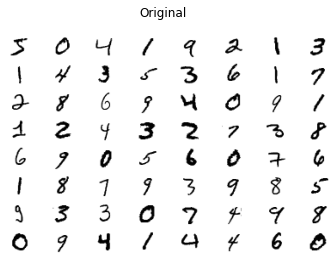

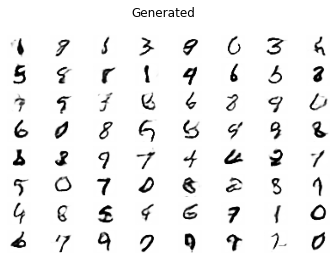

In [7]:
#display results
def img_grid(imgs, rows, cols, title):
    fig = plt.figure()
    for i, j in np.ndindex(rows, cols):
        plt.subplot(rows, cols, i*rows+j+1)
        plt.imshow(np.repeat(imgs[i*rows+j], 3, -1))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

cols = 8
rows = 8
inp = images_train[:cols*rows]
gen = model.generator.predict(np.random.normal(size=(cols*rows, 128)))
img_grid(inp, rows, cols, 'Original')
img_grid(gen, rows, cols, 'Generated')